Image credit: European Union, [Economies of scope in the aggregation of health-related data](https://joint-research-centre.ec.europa.eu/system/files/2021-09/jrc125767.pdf), under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

Python source: [451-blog/logreg.py at main · doabell/451-blog](https://github.com/doabell/451-blog/blob/main/posts/logistic-regression/logreg.py)

Instructions can be found at [Optimization for Logistic Regression](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-optimization.html).

## Comparing gradient descents
The [Python source file](https://github.com/doabell/451-blog/blob/main/posts/logistic-regression/logreg.py) implements three types of logistic regression with gradient descent:

- Batch gradient descent, updating the gradient all at once;
- Stochastic (minibatch) gradient descent, updating the gradient on random subsets;
- Stochastic (minibatch) gradient descent with momentum method.

### Note on terminology
I checked Google for a reasonable `batch_size` for this blog post's "stochastic gradient descent", and was unable to find one.

From [this Towards Data Science blog post](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a), it seems that "stochastic gradient descent" refers to an *online* method that checks one data point at a time.
A more common name for the method implemented in `LR.fit_stochastic()` is "minibatch" gradient descent, which strikes a balance between stochastic (one at a time) and "batch" (`LR.fit()`) gradient descent (all the data points, all at once).

### Batch gradient descent
With terminology out of the way, let us first prepare the data.

We generate data points with 2 features and 2 labels that are not linearly separable, as seen below:

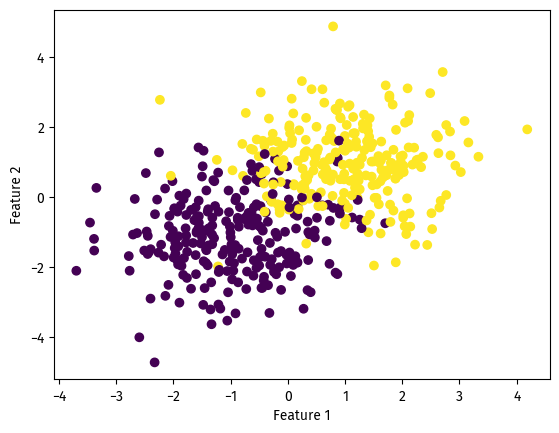

In [22]:
# Data
import numpy as np
from logreg import LogisticRegression
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")
plt.rcParams["font.family"] = "Fira Sans"
np.seterr(all='ignore')
np.random.seed(283)

# make the data
p_features = 3
X, y = make_blobs(
    n_samples=500, n_features=p_features - 1, centers=[(-1, -1), (1, 1)]
)

fig = plt.scatter(X[:, 0], X[:, 1], c=y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


We can then fit our logistic regression with *batch gradient descent* as follows:

array([ 1.82323946,  1.7608397 , -0.10917852])

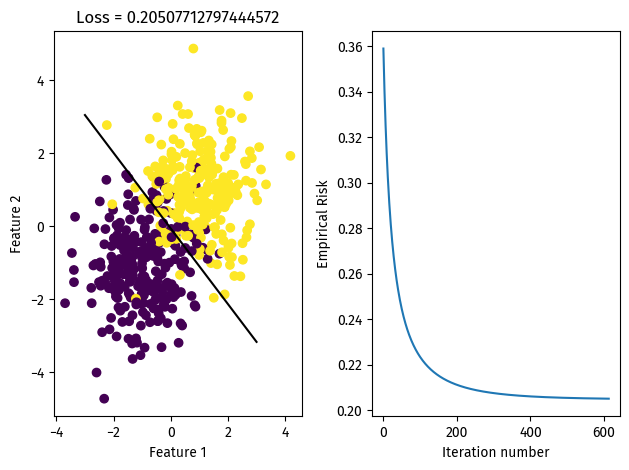

In [23]:
LR_batch = LogisticRegression()
LR_batch.fit(X, y, alpha=0.1, max_epochs=1000)

fig, axarr = plt.subplots(1, 2)

axarr[0].scatter(X[:, 0], X[:, 1], c=y)
axarr[0].set(
    xlabel="Feature 1", ylabel="Feature 2",
    title=f"Loss = {LR_batch.loss_history[-1]}"
)

f1 = np.linspace(-3, 3, 101)

p = axarr[0].plot(
    f1,
    (LR_batch.w[2] - f1*LR_batch.w[0])/LR_batch.w[1],
    color="black"
)

axarr[1].plot(LR_batch.loss_history)
axarr[1].set(xlabel="Iteration number", ylabel="Empirical Risk")
plt.tight_layout()


# inspect the fitted value of w
LR_batch.w


We observe a resonable splitting line on the left, and a smoothly decreasing loss to the right.

Since we also implemented stochastic "minibatch" gradient descent, with and without momentum, we can plot the loss curves together as follows:
(Code adapted from [blog post instructions](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-optimization.html#illustration))

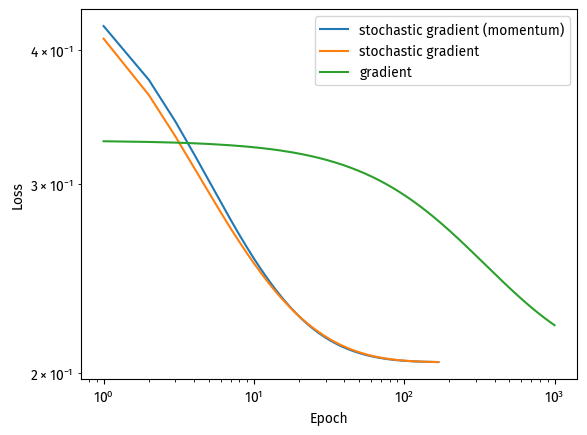

In [24]:
LR = LogisticRegression()
LR.fit_stochastic(
    X, y,
    max_epochs=1000,
    momentum=True,
    batch_size=10,
    alpha=.01
)

num_steps = len(LR.loss_history)
plt.plot(
    np.arange(num_steps) + 1, LR.loss_history,
    label="stochastic gradient (momentum)"
)

LR = LogisticRegression()
LR.fit_stochastic(
    X, y,
    max_epochs=1000,
    momentum=False,
    batch_size=10,
    alpha=.01
)

num_steps = len(LR.loss_history)
plt.plot(
    np.arange(num_steps) + 1, LR.loss_history,
    label="stochastic gradient"
)

LR = LogisticRegression()
LR.fit(X, y, alpha=.01, max_epochs=1000)

num_steps = len(LR.loss_history)
plt.plot(
    np.arange(num_steps) + 1,
    LR.loss_history,
    label="gradient"
)

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


We can see different converging speeds for the three types of gradient descent.
Here, stochastic "minibatch" gradient descent converges the fastest, then "minibatch" with momentum (slightly slower), then standard gradient descent.

## Experiments
Having compared the different ways of gradient descent, we now investigate the hyperparameters.
Namely:

- Learning rate $\alpha$
- Batch size
- Momentum vs. regular "minibatch" stochastic gradient descent

### Data
We will generate another dataset with 10 features, visualizing the first two:

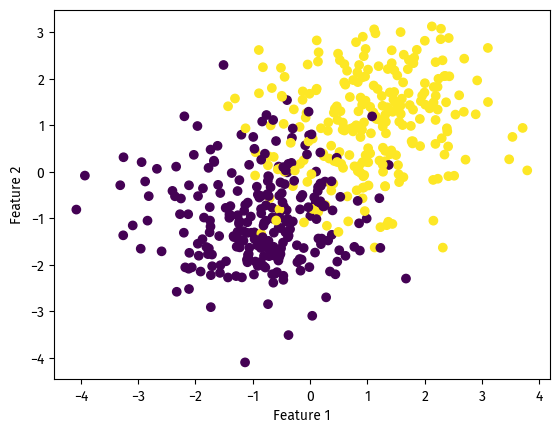

In [25]:
# make the data
p_features = 11
X, y = make_blobs(
    n_samples=500, n_features=p_features - 1, centers=[(-1, -1), (1, 1)]
)

fig = plt.scatter(X[:, 0], X[:, 1], c=y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


### Learning rate
The [learning rate](https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate) determines how much we move along the gradient.

In code , the relevant line, [Line 110](https://github.com/doabell/451-blog/blob/36d77a3ca4a0efa144f8a50cf8f40a55e8191378/posts/logistic-regression/logreg.py#L110), reads:

```python
self.w = self.w - alpha * gradient
```

As such, when the learning rate is too large, gradient descent will exceed the optimal minimum;
when it is too small, gradient descent will take longer to reach the optimal minimum.

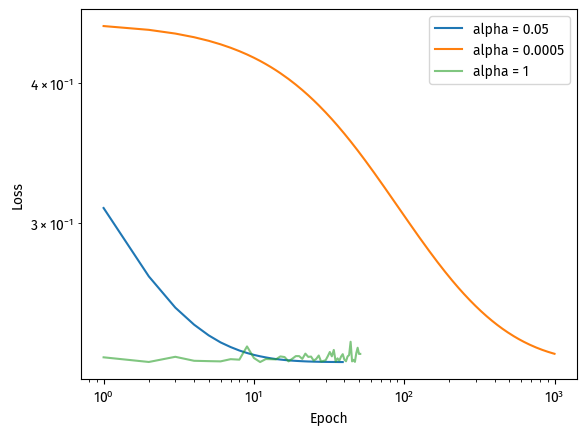

In [26]:
alphas = [0.05, 0.0005, 1]

for alpha in alphas:
    LR = LogisticRegression()
    LR.fit_stochastic(
        X, y,
        max_epochs=1000,
        momentum=False,
        batch_size=10,
        alpha=alpha
    )

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"alpha = {alpha}",
        alpha=0.6 if alpha == 1 else 1
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With three different learning rates, we can see a difference in how training loss progressed over time:

- Reasonably small, `alpha = 0.05`: loss decreased quickly, converging in less than 100 iterations.
- Too small, `alpha = 0.0005`: loss decreased more smoothly but slowly, and failed to converge in 1000 iterations.
- Too large, `alpha = 1`: loss jumped up and down frequently, although it managed to converge in less than 100 iterations.

This shows that indeed, we want a reasonably small learning rate.
Small enough to converge, but not too small that converging becomes too slow.

### Batch size
We look at another hyperparameter, the batch size.

In our "minibatch" gradient descent, we look at each "batch" separately.
The size of these batches, therefore, might determine the speed of gradient descent.

Using our reasonable learning rate of `alpha = 0.05`:


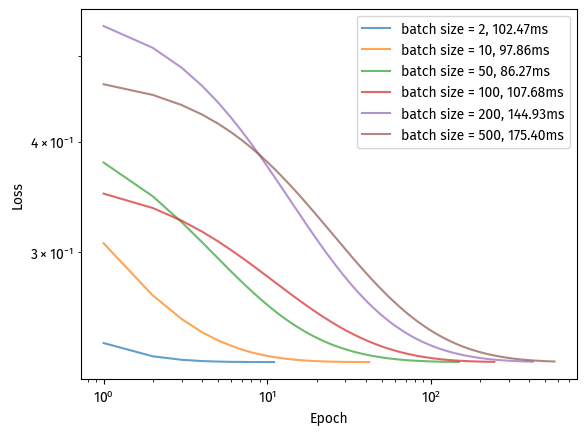

In [27]:
from time import perf_counter
batch_sizes = [2, 10, 50, 100, 200, 500]

for batch_size in batch_sizes:
    LR = LogisticRegression()
    start = perf_counter()
    LR.fit_stochastic(
        X, y,
        max_epochs=1000,
        momentum=False,
        batch_size=batch_size,
        alpha=0.05
    )
    end = perf_counter()

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"batch size = {batch_size}, {(end - start)*1000:.2f}ms",
        alpha=0.7
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")


Here, using otherwise identical hyperparameters, we observe that batch size does affect convergence speed and runtime.

Although a batch size of 2 converged the fastest, the program runtime was longer because of more calculations per loop.

A batch size of 50 converged rather quickly, and had a decently short runtime as well.

Larger batch sizes took longer to converge.
At a batch size of 500, this is effectively regular gradient descent, the one callable with `LR.fit()`.

In conclusion, a reasonable batch size would make gradient descent converge faster, and improve the program runtime as well.

### Momentum

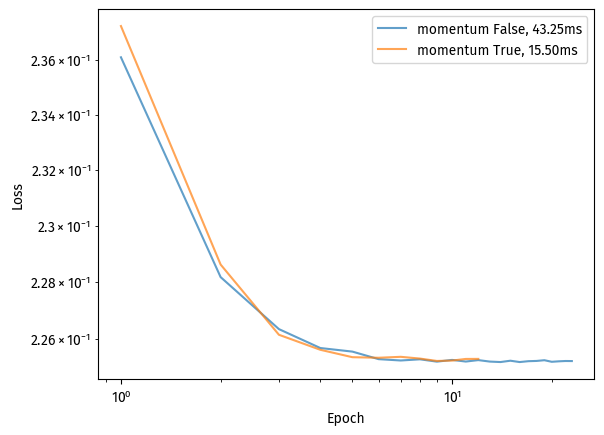

In [28]:
for momentum in [False, True]:
    LR = LogisticRegression()
    start = perf_counter()
    LR.fit_stochastic(
        X, y,
        max_epochs=100,
        momentum=momentum,
        batch_size=20,
        alpha=0.5
    )
    end = perf_counter()

    num_steps = len(LR.loss_history)
    plt.plot(
        np.arange(num_steps) + 1, LR.loss_history,
        label=f"momentum {momentum}, {(end - start)*1000:.2f}ms",
        alpha=0.7
    )

plt.loglog()

legend = plt.legend()
xlab = plt.xlabel("Epoch")
ylab = plt.ylabel("Loss")

With a large-enough learning rate of 0.5, we observe the power of the momentum method in gradient descent.

When using the momentum method, "minibatch" stochastic gradient descent converged in around 10 iterations.
Not using the momentum method resulted in a much slower convergence.